In [345]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
%matplotlib inline

The underlying asset with price $S$ follows geometric Brownian motion. The price is over time $t$ with a stochastic variable $W$ for Brownian motion, with the behavior being defined by the following stochastic differential equation.
$$\dfrac{dS}{S} = \mu dt + \sigma dW$$

In [570]:
# generate geometric Brownian motion sequence
def rand_walk_cont(n, mu=0, sigma=1, init=1, dt=0.01):
    sims = [init]
    # loop through n iterations
    for _ in range(n):
        sims.append(sims[-1] * np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt))))
    return np.array(sims)

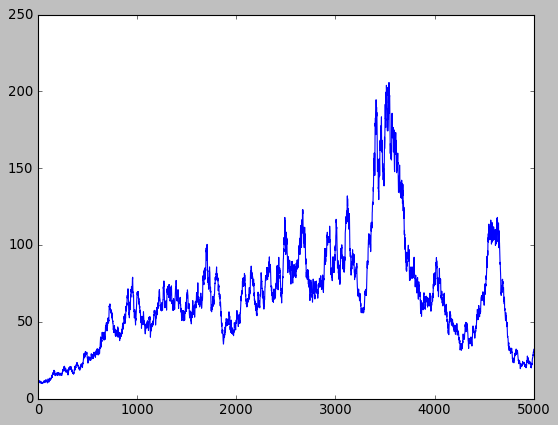

In [571]:
plt.plot(rand_walk_cont(n=5000, init=10, mu=1, sigma=1, dt=0.001))

Stochastic calculus is much more difficult to work with. Propose a discretization by the following. Want a random varible $X$ such that it has $-x, 0, x$ with equal probability and standard deviation $\sigma$. Standard deviation is $\sigma = \sqrt{\frac{1}{3}(-x)^2 + \frac{1}{3}(0)^2 + \frac{1}{3}(x)^2} = \sqrt{\dfrac{2}{3}}x$ so $x = \sqrt{3/2}\sigma$.

In [97]:
def discrete_sample(sigma):
    x = np.sqrt(3 / 2) * sigma
    return np.random.permutation([-1, 0, 1])[0] * x

In [98]:
# generate discrete approximation of geometric Brownian motion sequence
def rand_walk_disc(n, mu=0, sigma=1, init=1, dt=0.01):
    sims = [init]
    # loop through n iterations
    for _ in range(n):
        sims.append(sims[-1] * np.exp((mu - sigma ** 2 / 2) * dt + sigma * discrete_sample(np.sqrt(dt))))
    return sims

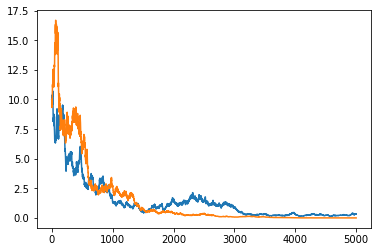

In [115]:
plt.plot(rand_walk_disc(n=5000, init=10, mu=0, sigma=1, dt=0.001))
plt.plot(rand_walk_cont(n=5000, init=10, mu=0, sigma=1, dt=0.001))

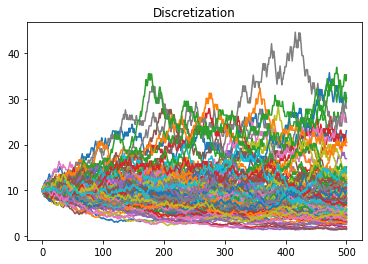

In [121]:
for _ in range(100):
    plt.plot(rand_walk_disc(n=500, init=10, mu=0, sigma=1, dt=0.001))
plt.title('Discretization')
plt.show()

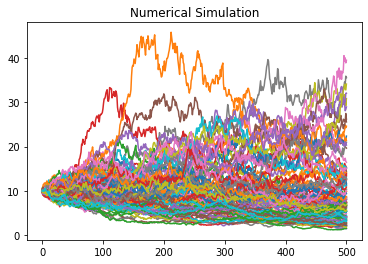

In [120]:
for _ in range(100):
    plt.plot(rand_walk_cont(n=500, init=10, mu=0, sigma=1, dt=0.001))
plt.title('Numerical Simulation')
plt.show()

## Black-Scholes Formula

The famed Black-Scholes formula, which is the analytical solution here, will be implemented below.

In [4]:
## implementation of Black-Scholes formula for European options (analytical solution)
def blackscholes_formula(sigma, time_remaining, S, K, r, optiontype):
    # intermediate calculations
    d1 = (1 / sigma * np.sqrt(time_remaining)) * (np.log(S / K) + (r + sigma ** 2 / 2) * time_remaining)
    d2 = d1 - sigma * time_remaining
    PV = K * np.exp(-r * time_remaining)
    
    if optiontype == 'call':
        return norm.cdf(d1) * S - norm.cdf(d2) * PV
    if optiontype == 'put':
        return norm.cdf(-d2) * PV - norm.cdf(-d1) * S

In [5]:
sigma = 0.5
time_remaining = 1
K = 1
r = 0
calls = [blackscholes_formula(sigma, time_remaining, S, K, r, 'call') for S in np.array(range(100)) / 50]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


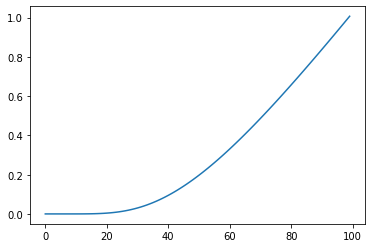

In [6]:
plt.plot(calls)

## Numerical Solution

In [21]:
### custom implementation of Gauss-Siedel method for tridiagonal matrix
def gauss_seidel(phi, b, nt, eps=1):
    
    # solution vector initialization
    x = [0 for _ in range(nt)]
    
    # creating tridiagonal coefficient matrix
    A = np.zeros(nt, nt)
    for i in range(nt):
        A[i, i] = 1 - 2 * phi
        # lower diagonal
        if i > 0:
            A[i, i - 1] = phi
        if i < nt - 1:
            A[i, i + 1] = phi
            
    # iterate until convergence
    while np.linalg.norm(np.dot(A, x) - b) > eps:
        x[0] = (b[0] - phi * x[1]) / (1 - 2 * phi)
        # solve solution vector iteratively
        for i in range(1, nt - 1):
            x[i] = (b[i] - a * (x[i - 1] + x[i + 1])) / (1 - 2 * phi)
    return x

In [489]:
# solution matrix, ns grid points for spot, nt grid points for time
def implicit(strike, r, nS, maxS, nt, maxt, sigma, optiontype='call'):
    # grid
    indexS = np.array(range(nS + 1))
    indext = np.array(range(nt + 1))
    gridS = indexS * maxS / nS
    gridt = indext * maxt / nt
    dS = gridS[1] - gridS[0]
    dt = gridt[1] - gridt[0]
    
    # solution matrix
    solutions = np.array([[None for _ in range(nt + 1)] for _ in range(nS + 1)])
    # boundary conditions
    if optiontype == 'call':
        solutions[:,-1] = np.maximum(gridS - strike, 0) # at exercise time
        solutions[0,:] = 0 # minimum price
        solutions[-1,:] = (gridS[-1] - strike) * np.exp(-r * gridt[::-1]) # maximum price
    if optiontype == 'put':
        solutions[:,-1] = np.maximum(strike - gridS, 0) # at exercise time
        solutions[0,:] = (strike - gridS[-1]) * np.exp(-r * gridt[::-1]) # minimum price
        solutions[-1,:] = 0 # maximum price
        
    a = (dt * (1 - 1 / indexS) / 2) * (r - sigma ** 2 * (1 - 1 / indexS))
    b = 1 + dt * (sigma ** 2 * (1 - 1 / indexS) * (1 - 1 / indexS) + r)
    c = -(dt * (1 - 1 / indexS) / 2) * (r + sigma ** 2 * (1 - 1 / indexS))
    
    # creating tridiagonal coefficient matrix
    A = np.zeros((nS - 1, nS - 1))
    for i in range(nS - 1):
        A[i, i] = b[i + 1]
        # lower diagonal
        if i > 0:
            A[i, i - 1] = a[i + 2]
        if i < nS - 2:
            A[i, i + 1] = c[i + 1]

    # iterative solving
    offset = np.zeros(len(solutions) - 2)
    for i in list(range(nt))[::-1]:
        offset[0] = a[1] * solutions[0, i]
        offset[-1] = c[-1] * solutions[-1, i]
        solutions[1:-1, i] = np.dot(np.linalg.inv(A), solutions[1:-1, i + 1] - offset)

    return solutions

In [427]:
maxS = 5
nS = 50
Srange = np.array(range(nS)) / (nS / maxS)
tr = 1
nums = implicit(strike=1, r=0, nS=nS, maxS=maxS, nt=100, maxt=2, sigma=0.5, optiontype='call')
ans = [blackscholes_formula(0.5, 1, S, K, 0, 'call') for S in Srange]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


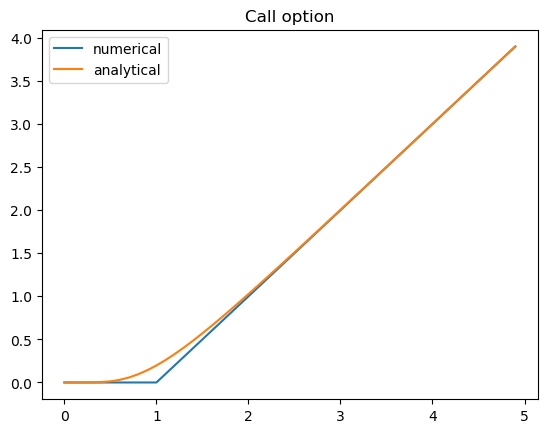

In [428]:
plt.style.use('default')
sns.lineplot(Srange, list(nums[:-1,-1]))
sns.lineplot(Srange, ans)
plt.legend(['numerical', 'analytical'])
plt.title('Call option')
plt.savefig('numerical.jpg')
plt.show()

In [429]:
maxS = 5
nS = 50
Srange = np.array(range(nS)) / (nS / maxS)
tr = 1
nums = implicit(strike=1, r=0, nS=nS, maxS=maxS, nt=100, maxt=2, sigma=0.5, optiontype='put')
ans = [blackscholes_formula(0.5, 1, S, K, 0, 'put') for S in Srange]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


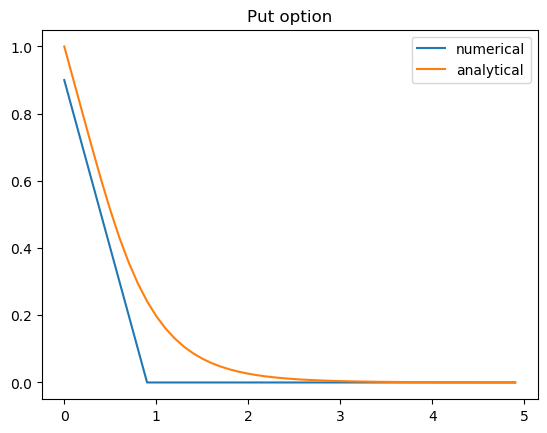

In [430]:
plt.style.use('default')
sns.lineplot(Srange, list(nums[1:,-1]))
sns.lineplot(Srange, ans)
plt.legend(['numerical', 'analytical'])
plt.title('Put option')
plt.savefig('numerical2.jpg')
plt.show()

In [517]:
maxS = 5
nS = 100
Srange = np.array(range(nS + 1)) / (nS / maxS)
tr = 1
k = 5
r = 0.3
sigma = 3
nums = implicit(strike=k, r=r, nS=nS, maxS=maxS, nt=10, maxt=tr, sigma=sigma, optiontype='call')
ans = [blackscholes_formula(sigma, tr, S, k, r, 'call') for S in Srange]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


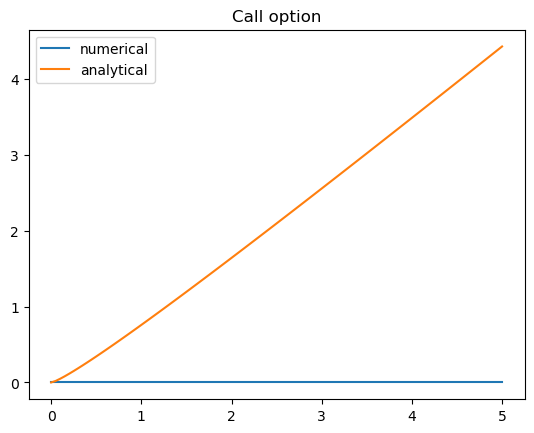

In [518]:
plt.style.use('default')
sns.lineplot(Srange, list(nums[:,0]))
sns.lineplot(Srange, ans)
plt.legend(['numerical', 'analytical'])
plt.title('Call option')
plt.show()

## plots

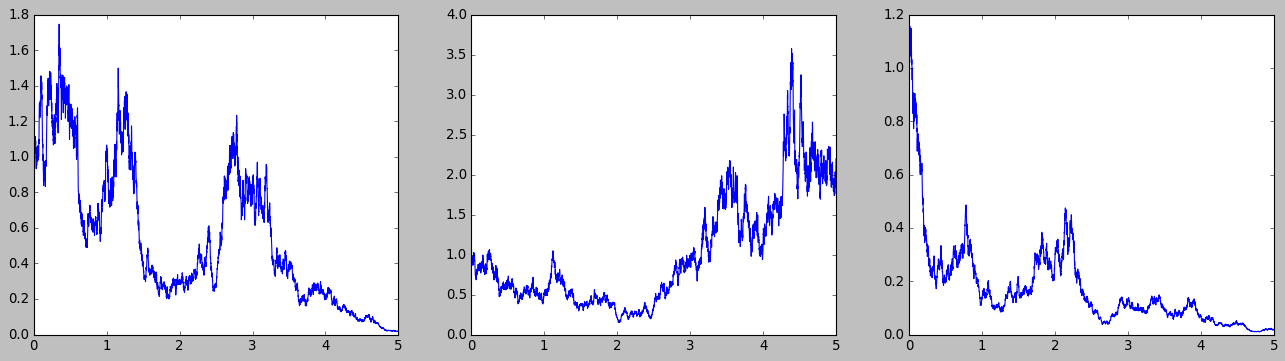

In [543]:
n = 5000
dt = 0.001
plt.style.use('classic')
plt.figure(figsize=(20, 5))

for i in range(3):
    asset = rand_walk_cont(n, mu=0, sigma=1, init=1, dt=dt)
    plt.subplot(1, 3, i + 1)
    plt.plot(np.linspace(0, n * dt, n + 1), asset)

plt.savefig('sims.jpg')
plt.show()

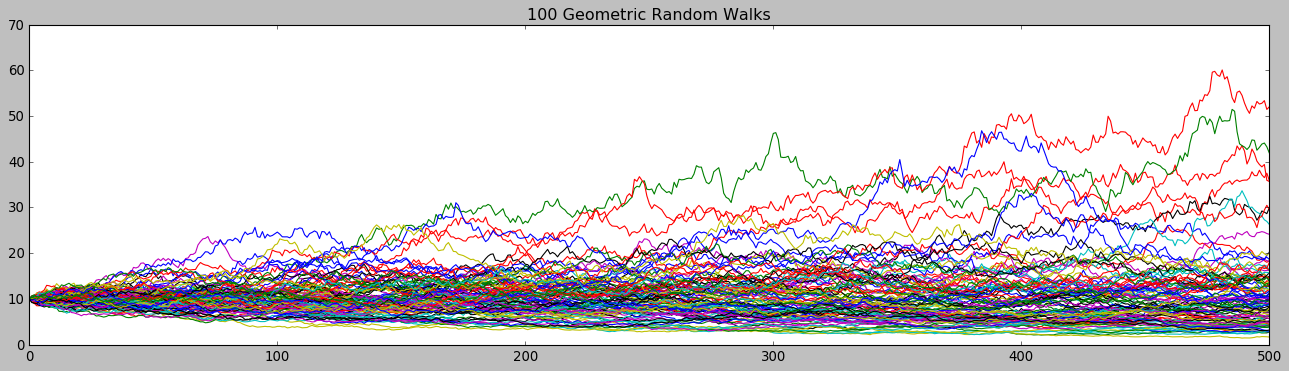

In [546]:
plt.style.use('classic')
plt.figure(figsize=(20, 5))
for _ in range(100):
    plt.plot(rand_walk_cont(n=500, init=10, mu=0, sigma=1, dt=0.001))
plt.title('100 Geometric Random Walks')
plt.savefig('agg.jpg')
plt.show()

## Dominant Balance

In [625]:
seed = 100

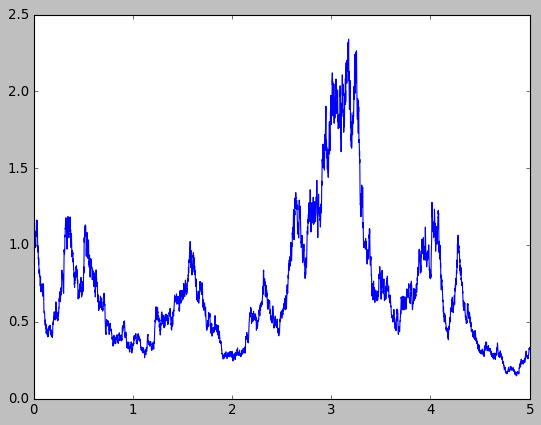

In [626]:
np.random.seed(seed)
# configuration
n = 5000
dt = 0.001
sigma = 1
timegrid = np.linspace(0, n * dt, n + 1)

# simulate
asset = rand_walk_cont(n, mu=0, sigma=sigma, init=1, dt=dt)

plt.style.use('classic')
plt.plot(timegrid, asset)
plt.show()

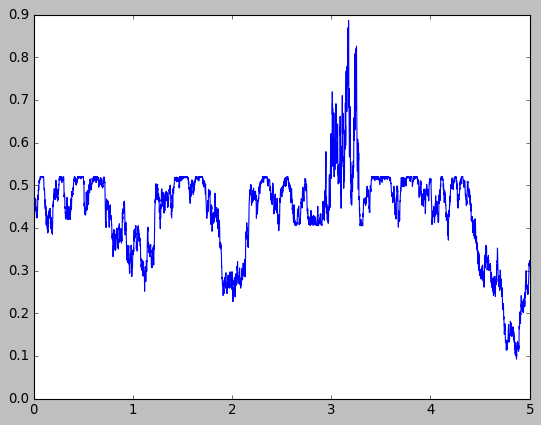

In [628]:
K = 2
r = 0.05
calls = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'call') for S in asset])
puts = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'put') for S in asset])
plt.plot(timegrid, calls)
plt.show()

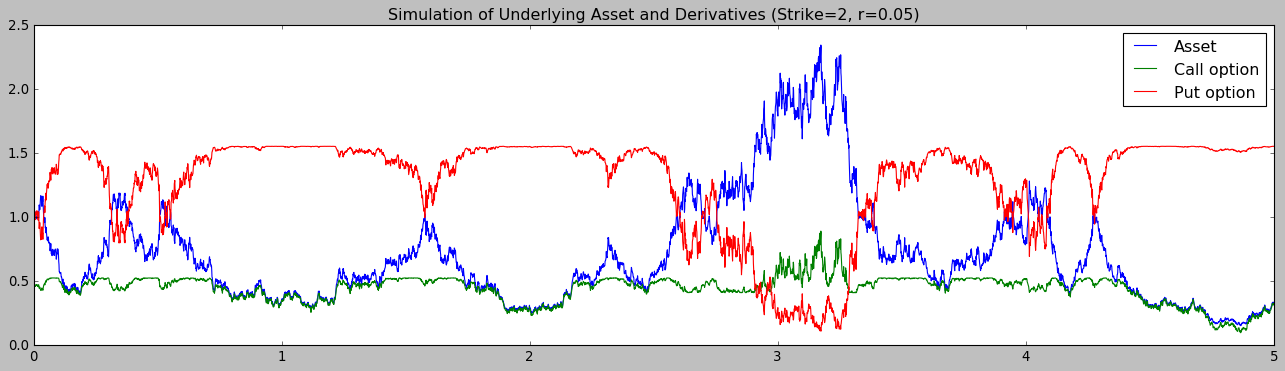

In [631]:
plt.figure(figsize=(20, 5))
plt.plot(timegrid, asset)
plt.plot(timegrid, calls)
plt.plot(timegrid, puts)
plt.legend(['Asset', 'Call option', 'Put option'])
plt.title('Simulation of Underlying Asset and Derivatives (Strike=' + str(K) + ', r=' + str(r) + ')')
plt.savefig('options.jpg')
plt.show()

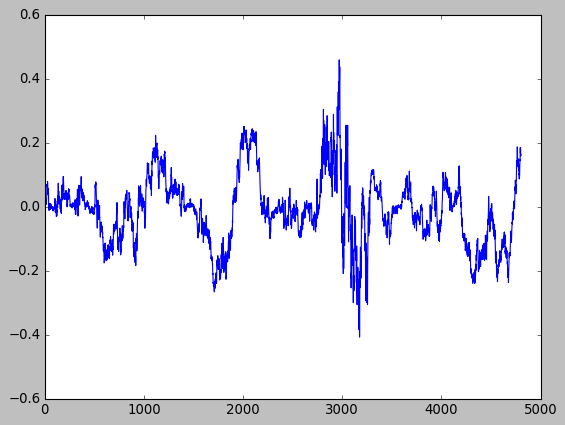

In [667]:
# time derivative
deltat = 100
dVdt = calls[(2 * deltat):] - calls[:-(2 * deltat)]
plt.plot(dVdt)

In [668]:
# second-order
d2VdS2 = 0.5 * sigma ** 2 * asset[deltat:-deltat] ** 2 * ((calls[(2 * deltat):] - 2 * calls[deltat:-deltat] + calls[:-(2 * deltat)]) / (asset[(2 * deltat):] - asset[:-(2 * deltat)]))
                                                          

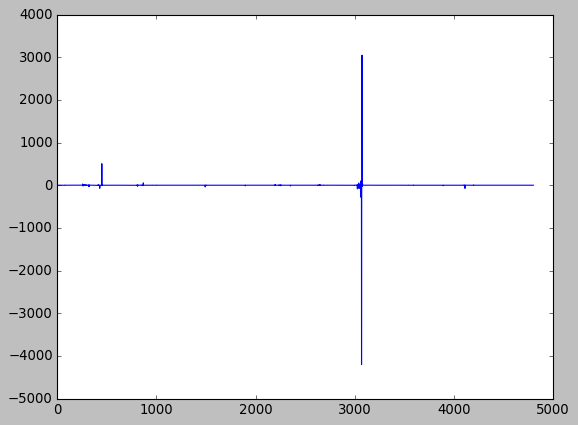

In [669]:
plt.plot(d2VdS2)

In [670]:
# sensitivity
dVdS = r * asset[(2 * deltat):] * (calls[(2 * deltat):] - calls[:-(2 * deltat)]) / (asset[(2 * deltat):] - asset[:-(2 * deltat)])

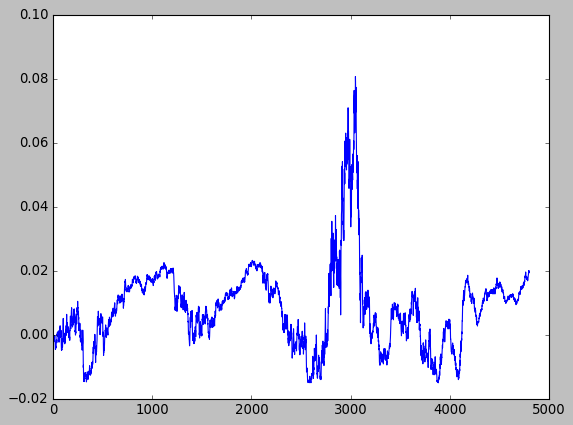

In [671]:
plt.plot(dVdS)

In [672]:
# last term
rV = r * calls[(2 * deltat):]

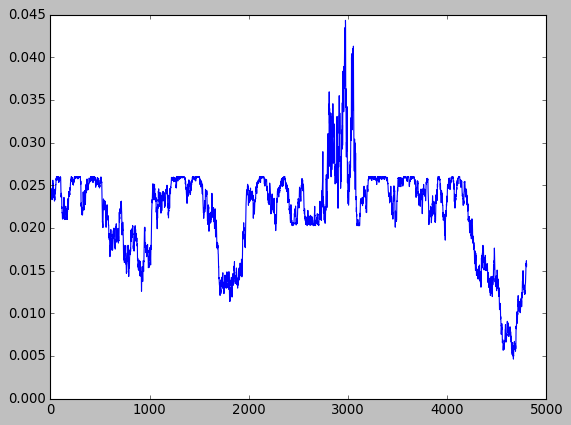

In [673]:
plt.plot(rV)

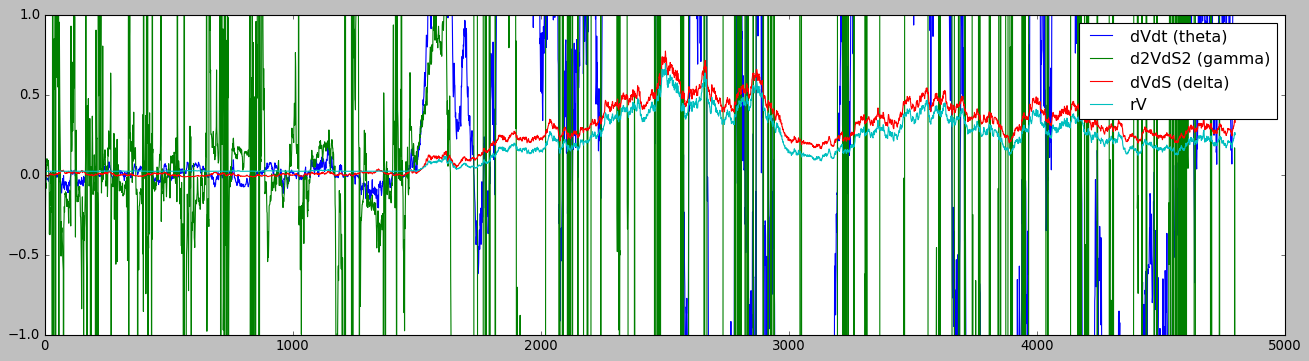

In [679]:
plt.figure(figsize=(20, 5))
plt.plot(dVdt)
plt.plot(d2VdS2)
plt.plot(dVdS)
plt.plot(rV)
plt.ylim(-1, 1)
plt.legend(['dVdt (theta)', 'd2VdS2 (gamma)', 'dVdS (delta)', 'rV'])
plt.savefig('dom.jpg')
plt.show()

Above work is collected and formalized in the following function.

In [702]:
def calc_terms(seed, sigma=1):
    np.random.seed(seed)
    # configuration
    n = 5000
    dt = 0.001
    timegrid = np.linspace(0, n * dt, n + 1)

    # simulate
    asset = rand_walk_cont(n, mu=0, sigma=sigma, init=1, dt=dt)

    # calculate options prices using black-scholes formula
    K = 2
    r = 0.05
    calls = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'call') for S in asset])
    puts = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'put') for S in asset])
    
    # time derivative
    deltat = 100
    dVdt = calls[(2 * deltat):] - calls[:-(2 * deltat)]
    
    # second-order
    d2VdS2 = 0.5 * sigma ** 2 * asset[deltat:-deltat] ** 2 * ((calls[(2 * deltat):] - 2 * calls[deltat:-deltat] + calls[:-(2 * deltat)]) / (asset[(2 * deltat):] - asset[:-(2 * deltat)]))

    # sensitivity
    dVdS = r * asset[(2 * deltat):] * (calls[(2 * deltat):] - calls[:-(2 * deltat)]) / (asset[(2 * deltat):] - asset[:-(2 * deltat)])
    
    # last term
    rV = r * calls[(2 * deltat):]
    
    return timegrid[(2 * deltat):], dVdt, d2VdS2, dVdS, rV

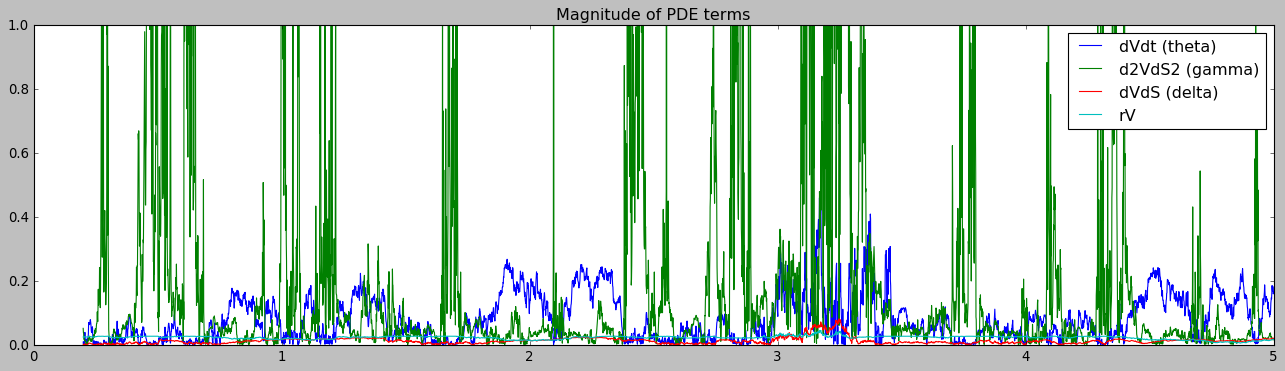

In [690]:
timegrid, dVdt, d2VdS2, dVdS, rV = calc_terms(100)
plt.figure(figsize=(20, 5))
plt.plot(timegrid, abs(dVdt))
plt.plot(timegrid, abs(d2VdS2))
plt.plot(timegrid, abs(dVdS))
plt.plot(timegrid, abs(rV))
plt.ylim(0, 1)
plt.legend(['dVdt (theta)', 'd2VdS2 (gamma)', 'dVdS (delta)', 'rV'])
plt.title('Magnitude of PDE terms')
plt.savefig('dom.jpg')
plt.show()

In [699]:
dVdts = []
d2VdS2s = []
dVdSs = []
rVs = []
for i in range(50):
    _, dVdt, d2VdS2, dVdS, rV = calc_terms(100 + i)
    dVdts.append(dVdt)
    d2VdS2s.append(d2VdS2)
    dVdSs.append(dVdS)
    rVs.append(rV)

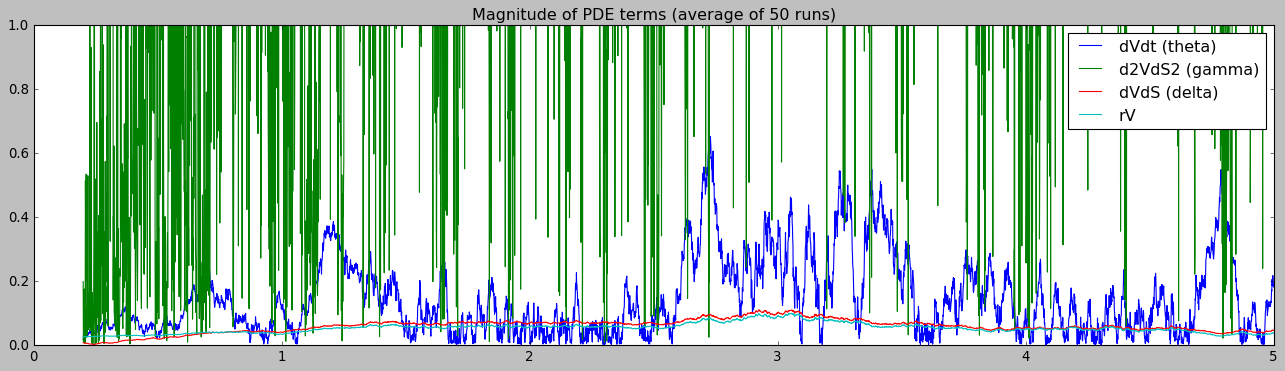

In [701]:
plt.figure(figsize=(20, 5))
plt.plot(timegrid, abs(np.mean(np.array(dVdts), axis=0)))
plt.plot(timegrid, abs(np.mean(np.array(d2VdS2s), axis=0)))
plt.plot(timegrid, abs(np.mean(np.array(dVdSs), axis=0)))
plt.plot(timegrid, abs(np.mean(np.array(rVs), axis=0)))
plt.ylim(0, 1)
plt.legend(['dVdt (theta)', 'd2VdS2 (gamma)', 'dVdS (delta)', 'rV'])
plt.title('Magnitude of PDE terms (average of 50 runs)')
plt.savefig('dommean.jpg')
plt.show()

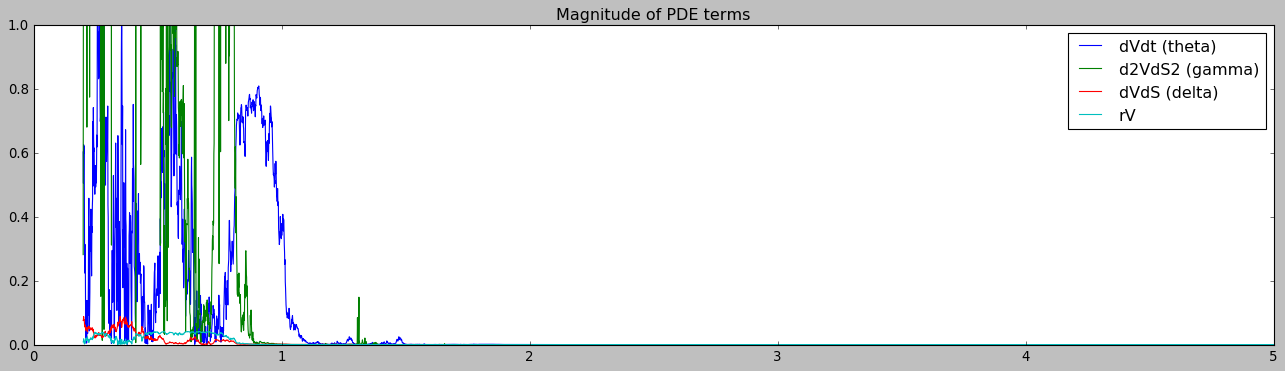

In [736]:
timegrid, dVdt, d2VdS2, dVdS, rV = calc_terms(10, sigma=3)
plt.figure(figsize=(20, 5))
plt.plot(timegrid, abs(dVdt))
plt.plot(timegrid, abs(d2VdS2))
plt.plot(timegrid, abs(dVdS))
plt.plot(timegrid, abs(rV))
plt.ylim(0, 1)
plt.legend(['dVdt (theta)', 'd2VdS2 (gamma)', 'dVdS (delta)', 'rV'])
plt.title('Magnitude of PDE terms')
# plt.savefig('dom.jpg')
plt.show()

In [737]:
# implementation of Black-Scholes formula for European options (Integral Approximation)
def blackscholes_formula_int_approx(sigma, time_remaining, S, K, r, optiontype, method):
    # intermediate calculations
    d1 = (1 / sigma * np.sqrt(time_remaining)) * (np.log(S / K) + (r + sigma ** 2 / 2) * time_remaining)
    d2 = d1 - sigma * time_remaining
    PV = K * np.exp(-r * time_remaining)

    if method == "Shah":
        def cdf(z):
            if z < 0:
                return 1 - cdf(-z)
            elif z <= 2.2:
                return 0.5 + z*(4.4-z)/10
            elif z > 2.2 and z < 2.6:
                return 0.5 + 0.49
            elif z > 2.6:
                return 1
    elif method == "Sigmoid":
        cdf = lambda z: 1 / (1 + np.exp(-np.sqrt(np.pi)*(-0.0004406 * z**5 + 0.0418198 * z**3 + 0.9 * z)))
    elif method == "Taylor":
        cdf = lambda z: 0.5 + 0.398942*z - 0.066490*z**3 + 0.09974*z**5 if (z >= 0) else 1-cdf(-1*z)
    elif method == "HPM":
        cdf = lambda z: 0.5 + 1/2 * np.tanh(39*z/(2*np.sqrt(2*np.pi)) - 111/2 * np.arctan(35*z/(111*np.sqrt(2*np.pi))))
    else:
        raise ValueError("Integral Approximation Method Not Valid")

    if optiontype == 'call':
        return cdf(d1) * S - cdf(d2) * PV
    if optiontype == 'put':
        return cdf(-d2) * PV - cdf(-d1) * S

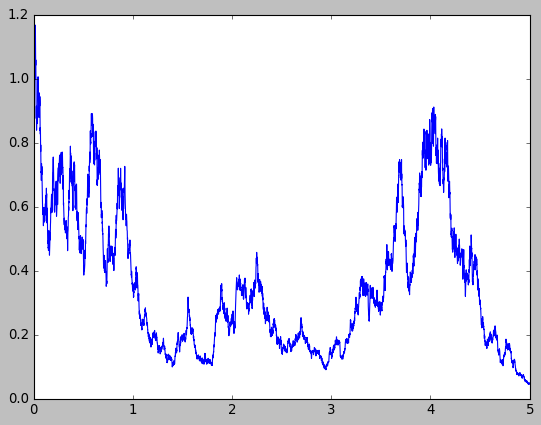

In [738]:
np.random.seed(150)
# configuration
n = 5000
dt = 0.001
sigma = 1
timegrid = np.linspace(0, n * dt, n + 1)

# simulate
asset = rand_walk_cont(n, mu=0, sigma=sigma, init=1, dt=dt)

plt.style.use('classic')
plt.plot(timegrid, asset)
plt.show()

In [742]:
K = 2
r = 0.05
calls = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'call') for S in asset])
puts = np.array([blackscholes_formula(sigma, n * dt, S, K, r, 'put') for S in asset])

In [743]:
callsapprox = np.array([blackscholes_formula_int_approx(sigma, n * dt, S, K, r, 'call', method='Shah') for S in asset])
putsapprox = np.array([blackscholes_formula_int_approx(sigma, n * dt, S, K, r, 'put', method='Shah') for S in asset])

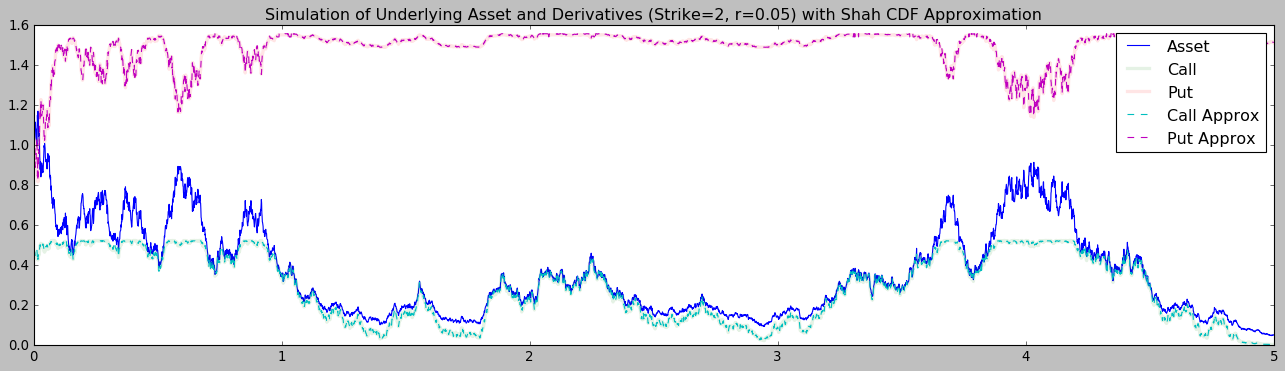

In [767]:
plt.figure(figsize=(20, 5))
plt.plot(timegrid, asset, linewidth=1)
plt.plot(timegrid, calls, linewidth=3, alpha=0.1)
plt.plot(timegrid, puts, linewidth=3, alpha=0.1)
plt.plot(timegrid, callsapprox, linestyle='--', linewidth=1)
plt.plot(timegrid, putsapprox, linestyle='--', linewidth=1)
plt.legend(['Asset', 'Call', 'Put', 'Call Approx', 'Put Approx'])
plt.title('Simulation of Underlying Asset and Derivatives (Strike=' + str(K) + ', r=' + str(r) + ') with Shah CDF Approximation')
plt.savefig('approxshah.jpg')
plt.show()

In [768]:
def eval(method):
    callsapprox = np.array([blackscholes_formula_int_approx(sigma, n * dt, S, K, r, 'call', method=method) for S in asset])
    putsapprox = np.array([blackscholes_formula_int_approx(sigma, n * dt, S, K, r, 'put', method=method) for S in asset])
    plt.figure(figsize=(20, 5))
    plt.plot(timegrid, asset, linewidth=1)
    plt.plot(timegrid, calls, linewidth=3, alpha=0.1)
    plt.plot(timegrid, puts, linewidth=3, alpha=0.1)
    plt.plot(timegrid, callsapprox, linestyle='--', linewidth=1)
    plt.plot(timegrid, putsapprox, linestyle='--', linewidth=1)
    plt.legend(['Asset', 'Call', 'Put', 'Call Approx', 'Put Approx'])
    plt.title('Simulation of Underlying Asset and Derivatives (Strike=' + str(K) + ', r=' + str(r) + ') with ' + method + ' CDF Approximation')
    plt.savefig('approx' + method + '.jpg')
    plt.show()

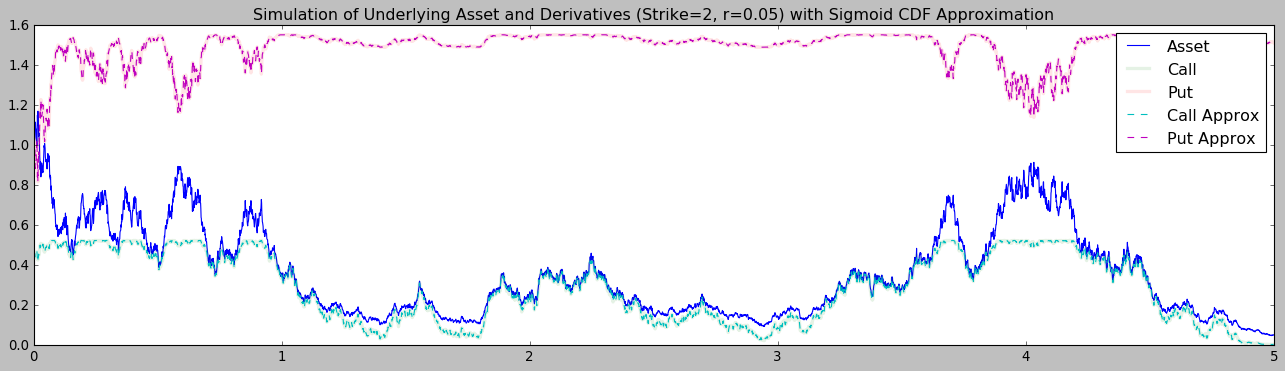

In [769]:
eval('Sigmoid')

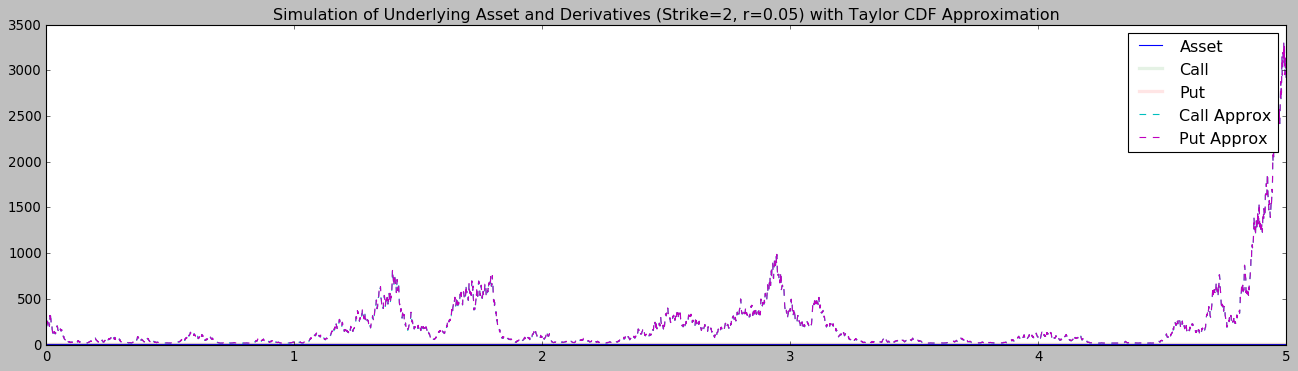

In [770]:
eval('Taylor')

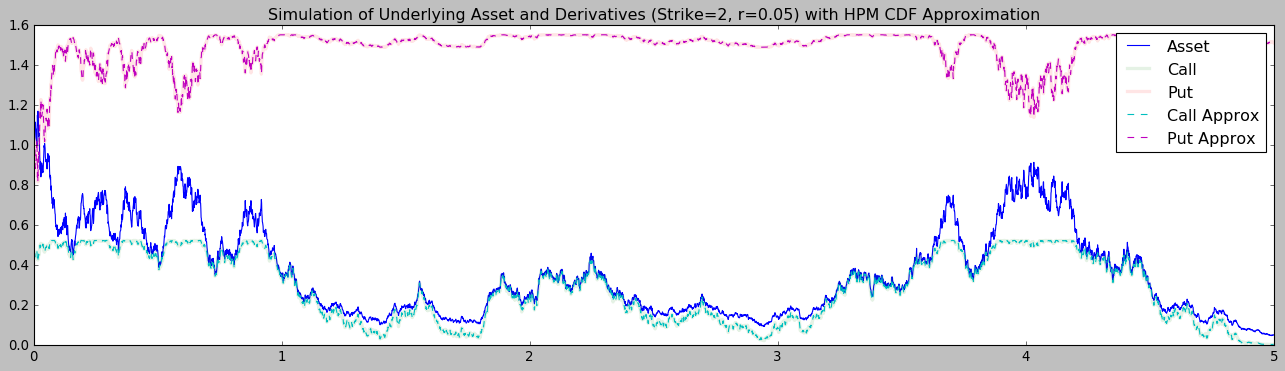

In [772]:
eval('HPM')